<a href="https://colab.research.google.com/github/smlacava/Themis/blob/main/CV_face_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3DMM-based 3D face reconstruction
Demo of a 3D face reconstruction based on a 3DMM (3D Morphological Model) from a single RGB image.

# Initial settings



## Automatic settings

*   Import and installation of the libraries used
*   Downloading useful files and repositories

In [ ]:
!git clone https://github.com/patrikhuber/eos

fatal: destination path 'eos' already exists and is not an empty directory.


In [ ]:
!pip install eos-py

     |████████████████████████████████| 2.1 MB 28.7 MB/s 
  Created wheel for eos-py: filename=eos_py-1.2.1-cp37-cp37m-linux_x86_64.whl size=399028 sha256=aba4bbdbee8d704f2d5c6cd67c94ba9a18d8188a8371f9aae4c4c2940419920d
  Stored in directory: /root/.cache/pip/wheels/0c/ac/4d/3284e0d8b8ab97efcd57c3cffd887e91f9446d881d1c3f0d88
Successfully built eos-py


In [ ]:
!wget dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

--2022-03-09 15:05:34--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  16.9MB/s    in 3.6s    

2022-03-09 15:05:37 (16.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
import numpy as np
import dlib
import eos
import cv2
import pandas as pd
from google.colab import files
import io
import os
from PIL import Image
import matplotlib.pyplot as plt

## Upload the input file

Automatic reconstruction from a selected local png or jpg image

In [ ]:
imgPath = "face-recon"

try:
  os.mkdir(imgPath)
  print(imgPath+" created.")
except:
  print(imgPath+" already exists.")

os.chdir(imgPath)
if "fname" in locals():
  try:
    os.remove(fname)
    print("Previous image removed.")
  except:
    print("The file cannot be removed.")
fname = files.upload()
os.chdir("..")


fname = list(fname.keys())[0]

face-recon already exists.
Previous image removed.


Saving 001_01_01_051_06_crop_128.png to 001_01_01_051_06_crop_128.png


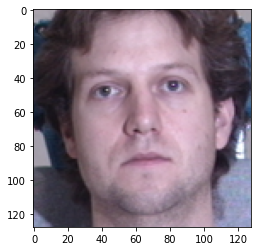

In [ ]:
img = cv2.imread(imgPath+"/"+fname)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 3D face reconstruction
Shape estimation and texture extraction from the input 2D image.

## Landmarks estimation

In [ ]:
detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

model = eos.morphablemodel.load_model("eos/share/sfm_shape_3448.bin")
blendshapes = eos.morphablemodel.load_blendshapes("eos/share/expression_blendshapes_3448.bin")
morphablemodel_with_expressions = eos.morphablemodel.MorphableModel(
    model.get_shape_model(), 
    blendshapes,
    color_model=eos.morphablemodel.PcaModel(),
    vertex_definitions=None,
    texture_coordinates=model.get_texture_coordinates()
)

landmark_mapper = eos.core.LandmarkMapper('eos/share/ibug_to_sfm.txt')
edge_topology = eos.morphablemodel.load_edge_topology('eos/share/sfm_3448_edge_topology.json')
contour_landmarks = eos.fitting.ContourLandmarks.load('eos/share/ibug_to_sfm.txt')
model_contour = eos.fitting.ModelContour.load('eos/share/sfm_model_contours.json')

In [ ]:
boxes = detector(img)
lp = []
for box in boxes:
    shape = shape_predictor(img, box)
    index = 1
    landmarks = []
    for i in range(shape.num_parts):
        landmarks.append(eos.core.Landmark(str(index),[shape.part(i).x, shape.part(i).y]))
        index +=1
    lp.append(landmarks)

## Texture extraction

In [ ]:
h,w = img.shape[:2]
landmark_ids = list(map(str, range(1, 69)))
canvas = img.copy()
for idx, landmarks in enumerate(lp):
    mesh, pose, shape_coeffs, blendshape_coeffs = eos.fitting.fit_shape_and_pose(
        morphablemodel_with_expressions,
        landmarks, landmark_mapper, w, h, edge_topology, 
        contour_landmarks,model_contour)
    isomap = eos.render.extract_texture(mesh, pose, cv2.cvtColor(canvas, cv2.COLOR_RGB2RGBA))
    cv2.imwrite(imgPath+"/face.texture" + str(idx)+ ".png", isomap)

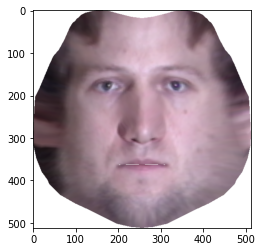

In [ ]:
plt.imshow(cv2.cvtColor(isomap, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
import copy

def _interpolate(img, r, c, rows, columns, channel):
  N = 2
  #return aux[rows-r+1, columns-c+1, channel]
  #return aux[r-1, c-1, channel]*2-aux[r-2, c-2, channel]
  return (img[r-1, c-1, channel]*2-img[r-2, c-2, channel])*0.95+img[rows-r+1, columns-c+1, channel]*0.05

def isomap_interpolation(isomap):
  aux = copy.deepcopy(isomap)

  gray = cv2.cvtColor(isomap, cv2.COLOR_BGR2GRAY)
  eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')
  smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_smile.xml')
  eyes =  eyes_cascade.detectMultiScale(gray, 1.3, 5)
  smile =  smile_cascade.detectMultiScale(gray, 1.7, 11)
  (_, y_max, _, _) = smile[0]
  (x_min, y, _, h) = eyes[0]
  (x, _, w, _) = eyes[1]
  x_max = x+w
  y_min = y+h

  (rows, columns, channels) = aux.shape
  for r in range(y_min, y_max):
    for c in range(x_min, x_max):
      if aux[r, c, 3] == 0 and aux[r, c, 0] == 255 and aux[r, c, 1] == 255 and aux[r, c, 2] == 255:
        aux[r, c, 0] = _interpolate(aux, r, c, rows, columns, 0)
        aux[r, c, 1] = _interpolate(aux, r, c, rows, columns, 1)
        aux[r, c, 2] = _interpolate(aux, r, c, rows, columns, 2)
  return aux

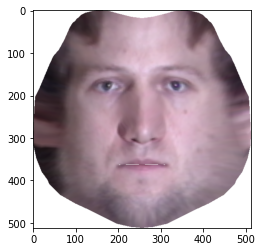

In [ ]:
isomap = isomap_interpolation(isomap)
plt.imshow(cv2.cvtColor(isomap, cv2.COLOR_BGR2RGB))
plt.show()

## Shape estimation

In [ ]:
name = "pface"
texture_file = imgPath+"/"+name+".texture.png"
shape_file = imgPath+"/"+name+".obj"
mtl_file = imgPath+"/"+name+".mtl"

In [ ]:
(mesh, pose, shape_coeffs, blendshape_coeffs) = eos.fitting.fit_shape_and_pose(morphablemodel_with_expressions,
        landmarks, landmark_mapper, w, h, edge_topology, contour_landmarks, model_contour)
eos.core.write_textured_obj(mesh, shape_file)

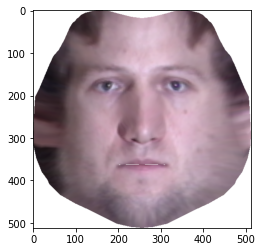

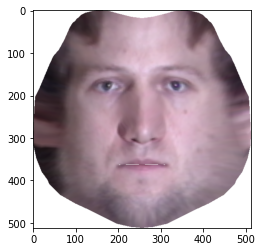

True

In [ ]:
mesh, pose, shape_coeffs, blendshape_coeffs = eos.fitting.fit_shape_and_pose(
  morphablemodel_with_expressions,
  landmarks, landmark_mapper, w, h, edge_topology, 
  contour_landmarks,model_contour)
isomap = eos.render.extract_texture(mesh, pose, cv2.cvtColor(canvas, cv2.COLOR_RGB2RGBA))
plt.imshow(cv2.cvtColor(isomap ,cv2.COLOR_BGR2RGB))
plt.show()
int_isomap = isomap_interpolation(isomap)
plt.imshow(cv2.cvtColor(int_isomap ,cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite(texture_file, int_isomap)
#cv2.imwrite(texture_file, isomap)

## Reconstructed 3D face

In [ ]:
files.download(mtl_file) 
files.download(shape_file) 
files.download(texture_file) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>